# Chapter 9 - Recurrent Neural Networks

**Recurrent neural networks** (RNNs) are deep learning models that capture the dynamics of sequences via *recurrent connections*, which can be thought of as cycles in the network of nodes. 

Recurrent neural networks are *unrolled* across time steps (or sequence steps), with the *same underlying parameters* applied at each step.

While the standard connections are applied *synchronously* to propagate each layer’s activations to the subsequent layer *at the same time step*, the recurrent connections are *dynamic*, passing information across adjacent time steps.

![](../imgs/ch09/unfolded-rnn.svg)

RNNs can be thought of as feedforward neural networks where each layer's parameters (both conventional and recurrent) are shared across time steps.

## 9.1. Working with Sequences

When developing models capable of processing sequences, we focus on inputs that consist of an ordered list of feature vectors $\mathbf{x}_1, \ldots, \mathbf{x}_T$, where each feature vector $\mathbf{x}_t$ is indexed by a time step $t \in \mathbb{Z}^+$ lying in $\mathbb{R}^d$.

For sequential data, we still assume that the entire sequences are sampled independently from the same underlying distribution, but we cannot assume that the data arriving at each time step are independent of each other.

We can predict a fixed target $y$ given sequentially structured input (e.g., sentiment classification based on a movie review). Or, we can predict a sequentially structured target ($y_1, \ldots, y_T$) given a fixed input (e.g., image captioning). Or, we can predict sequentially structured targets based on sequentially structured inputs (e.g., machine translation or video captioning). Such sequence-to-sequence tasks take two forms:
1. *aligned*: where the input at each time step aligns with a corresponding target (e.g., part of speech tagging);
2. *unaligned*: where the input and target do not necessarily exhibit a step-for-step correspondence (e.g., machine translation).

In [2]:
%matplotlib inline
import torch
from torch import nn

from d2l import torch as d2l

### 9.1.1. Autoregressive Models

Consider the stock price data from the FTSE 100 index in the figure below. At each *time step* $t\in\mathbb{Z}^+$, we observe a price $x_t$ of the index at that time.

<img src="../imgs/ch09/ftse100.png" alt="FTSE 100" width="500">

Suppose a trader would like to make short-term trades, absent any other features (news, financial reporting data, etc) and the only available signal for predicting the subsequent value is the history of prices to date. The trader is interested in knowning the probability distribution
\begin{split}
P(x_t \mid x_{t-1}, \ldots, x_1)
\end{split}
over prices that the index might take in the subsequent time step. The trader would be happy to focus on a few key statistics of this distribution, particularly the expected value and the variance. One stratepy for estimating the conditional expectation
\begin{split}
\mathbb{E}[(x_t \mid x_{t-1}, \ldots, x_1)]
\end{split}
would be to apply a linear regression model. Such models that regress the value of a signal on the previous values of that same signal are called *autoregressive models*.

### 9.1.2. Sequence Models

When working with language, we wish to estimate the joint probability of an entire sequence, which is a common task when working with sequences composed of discrete *tokens*, such as words. These esimated functions are called *sequence models* and for natural language data, they are called *language models*.

We can reduce language modeling to autoregressive prediction by decomposing the joint density of a sequence $p(x_1, \ldots, x_T)$ into the product of conditional densities in a left-to-right fashion by applying the chain rule of probability:
\begin{split}
P(x_1, \ldots, x_T) = P(x_1) \prod_{t=2}^T P(x_t \mid x_{t-1}, \ldots, x_1)
\end{split}

If we work with discrete signals such as words, then the *autoregresive model* must be a probabilistic classifier, outputting a fully probability distribution over the vocabulary for whatever word will come next, given the leftwards context.

#### 9.1.2.1. Markov Models

Suppose we use the above strategy and condition only on the $\tau$ previous time steps, i.e., $x_{t-1}, \ldots, x_{t-\tau}$, rather than the entire sequence history $x_{t-1}, \ldots, x_1$. This is called a *Markov condition*, i.e., that *the future is conditionally independent of the past, given the recent history*.

When $\tau=1$, the data is characterized by a *first-order Markov model*. When $\tau=k$, the data is characterized by a *$k$th-order Markov model*.

When the first-order Markov condition holds (i.e., $\tau=1$), the factorization of out joint probability becomes a product of probabilities of each word given the previous *word*:
\begin{split}
P(x_1, \ldots, x_T) = P(x_1) \prod_{t=2}^T P(x_t \mid x_{t-1})
\end{split}

With discrete data, a true Markov model counts the number of times that each word has occurred in each context, producing the relative frequency estimate of $P(x_t \mid x_{t-1})$. Whenever the data assumes only discrete values (as in language), the most likely sequence of words can be computed efficiently using dynamic programming.

#### 9.1.2.2. The Order of Decoding

We can also unfold $P(x_1, \ldots, x_T)$ in reverse order, and the result is a valid factorization:
\begin{split}
P(x_1, \ldots, x_T) = P(x_T) \prod_{t=T-1}^1 P(x_t \mid x_{t+1}, \ldots, x_T)
\end{split}

Even if we have no other reason to prefer such in-order decodings (left-to-right), thye would be useful if only because we have better intuitions for what should be likely when predicting in this order.

Also, by factorizing in order, we can assign probabilities to arbitrarily long sequences using the same language model. To convert a probability over steps 1 throught $t$ into one that extends to word $t+1$, we simply multiply by the conditional probability of the additional token given the previous ones: $P(x_{t+1}, \ldots, x_1) = P(x_t, \ldots, x_1) \cdot P(x_{t+1} \mid x_t, \ldots, x_1)$.

Furthermore, we have stronger predictive models for predicting adjacent words than words at arbitrary other locations. This is also for data that is causally structured. We believe that future events cannot influence the past. Hence, if we change $x_t$, we may be able to influence what happens for $x_{t+1}$ going forward but not the converse. That is, if we change $x_t$, the distribution over past events will not change. This makes it easier to predict $P(x_{t+1} \mid x_t)$ than to predict $P(x_t \mid x_{t+1})$.

### 9.1.3. Training

In [3]:
# create synthetic data
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()

        self.time = torch.arange(1, T+1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

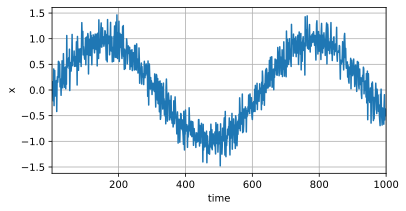

In [4]:
data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1,1000], figsize=(6,3))

We try a model taht acts as if the data satisfied a $\tau$th-order Markov condition, and predcits $x_t$ using only the past $\tau$ observations. For each time step we have an example with label $y=x$, and features $\mathbf{x}_t =[x_{t-\tau}, \ldots, x_{t-1}]$. 

This results in $1000-\tau$ examples, since we lack sufficient hisotry for $y_1, \ldots, y_{\tau}$. While we could pad the first $\tau$ sequences with zeros, to keep things simple, we drop them for now. The resulting dataset contains $T-\tau$ examples, where each input to the model has sequence length $\tau$. We create a data iterator on the first 600 examples, covering a period of the sin function:

In [5]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, dim=1)
    self.labels = self.x[self.tau:].reshape((-1, 1))

    i = slice(0, self.num_train) if train else slice(self.num_train, None)

    return self.get_tensorloader([self.features, self.labels], train, i)

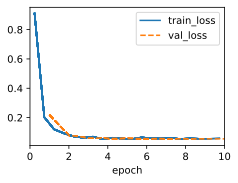

In [6]:
# create model (linear regression)
model = d2l.LinearRegression(lr=0.01)
# create trainer
trainer = d2l.Trainer(max_epochs=10)
# train model
trainer.fit(model, data)

### 9.1.4. Prediction

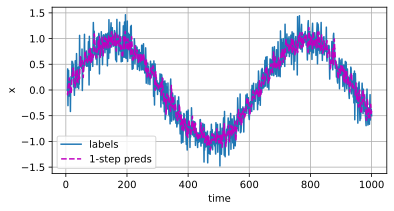

In [7]:
# perform at one-step-ahead prediction
onestep_preds = model(data.features).detach().numpy()

d2l.plot(data.time[data.tau:],
         [data.labels, onestep_preds],
         'time', 'x',
         legend=['labels', '1-step preds'],
         figsize=(6,3))

If we only observed sequence data up until time step 50 (`n_train + tau`) and wish to make predicitons several steps into the future, we cannot directly compute the one-step-ahead prediction for time step 55, because we do not know the corresponding inputs, having seen only up to $x_{50}$. We need to predict value at time step 55 based on the observations from time steps 50 through 54 one step at a time, until reaching the desired time step:
\begin{split}
\begin{aligned}
\hat{x}_{51} &= f(x_{47}, x_{48}, x_{49}, x_{50}), \\
\hat{x}_{52} &= f(x_{48}, x_{49}, x_{50}, \hat{x}_{51}), \\
\hat{x}_{53} &= f(x_{49}, x_{50}, \hat{x}_{51}, \hat{x}_{52}),\\
\hat{x}_{54} &= f(x_{50}, \hat{x}_{51}, \hat{x}_{52}, \hat{x}_{53}),\\
\hat{x}_{55} &= f(\hat{x}_{51}, \hat{x}_{52}, \hat{x}_{53}, \hat{x}_{54}),\\
&\vdots
\end{aligned}
\end{split}

Generally, for an observed sequence $x_1, \ldots, x_t$, its predicted output $\hat{x}_{t+k}$ at time step $t+k$ is called the $k$-*step-ahead prediction*. We have to keep on using our own predictions to make multistep predictions.

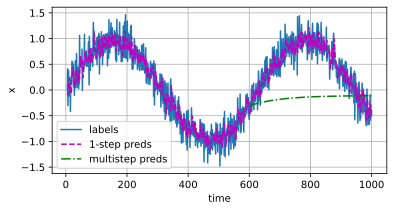

In [8]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x

for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau : i].reshape((1, -1))
    )
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], 
          data.time[data.tau:], 
          data.time[data.num_train+data.tau:]],
         [data.labels,
          onestep_preds, 
          multistep_preds[data.num_train + data.tau:]],
         'time', 'x',
         legend=['labels', '1-step preds', 'multistep preds'],
         figsize=(6, 3))

In this case, the model fails. The predictions decay to a constant pretty quickly after a few steps. This is because the erros build up in the predictions. This is a common phenomenon in autoregressive models. The errors tend to accumulate, and the model is unable to correct them, thus leading to a divergence from the true observations.

We can check the difficulties in $k$-step-ahead predictions for $k=1, 4, 16, 64$:

In [13]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T - data.tau - k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead prediction.
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], dim=1))
        features.append(preds.reshape(-1))

    return features[data.tau:]

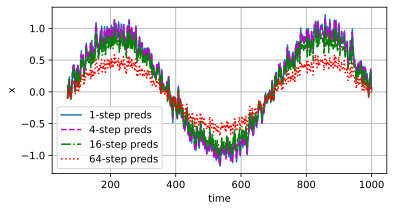

In [14]:
steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])

d2l.plot(data.time[data.tau + steps[-1]-1:],
         [preds[k-1].detach().numpy() for k in steps],
         'time', 'x',
         legend=[f'{k}-step preds' for k in steps],
         figsize=(6, 3))

This clearly illustrates how the quality of the prediction changes as we try to predict further into the future. While the 4-step-ahead predictions still look good, anything beyond that is almost useless.

## 9.2. Converting Raw Text into Sequence Data

To convert raw text into sequences of the appropriate form:
1. load text as strings into memory
2. split the strings into tokens (e.g., words or characters)
3. build a vocabulary dictionary to associate each vocabulary element with a numberical index
4. convert the text into sequences of numerical indices

In [15]:
import collections
import random
import re
import torch

from d2l import torch as d2l

### 9.2.1. Reading the Dataset

In [16]:
# H. G. Wells, The Time Machine
class TimeMachine(d2l.DataModule):
    '''The Time Machine dataset.'''
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', # url
                             self.root, # path
                             '090b5e7e70c295757f55df93cb0a180b9691891a', # sha1
                             )
        with open(fname) as f:
            return f.read()

In [17]:
# prepare data 
data = TimeMachine()
# download data
raw_text = data._download()
raw_text[:100]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Traveller (for so it will be convenient to '

In [18]:
# preprocess data
# to ignore puncutation and capitalization
@d2l.add_to_class(TimeMachine)
def _preprocess(self, text):
    res = re.sub('[^A-Za-z]+', # pattern to replace
                 ' ', # replace with space
                 text, # text to replace
                 )
    res = res.lower() # lowercase
    return res

In [19]:
# preprocess data
text = data._preprocess(raw_text)
text[:100]

'the time machine by h g wells i the time traveller for so it will be convenient to speak of him was '

### 9.2.2. Tokenization

*Tokens* are the atomic (indivisible) units of text. Each time step corresponds to 1 token, but what precisely constitutes a token is a design choice.

For now, we tokenize our preprocessed text into a sequence of characters:

In [20]:
@d2l.add_to_class(TimeMachine)
def _tokenize(self, text):
    return list(text)

In [21]:
tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

### 9.2.3. Vocabulary

The inputs to our models must consist of numerical inputs instead of string tokens. We must introduce a class for constructing *vocabularies*, i.e., objects that associate each distinct token value with a unique index.

1. We determine the set of unique tokens in our training *corpus* (a dataset of text for training a language model).
2. We assign a numerical index to each unique token. Rare vocabulary elements are often discarded for convenience.

Whenever we encounter a token at training or test time that had not been previously seen or was dropped from the vocabulary, we represent it by a special "<unk>" token, signifying that this is an *unknown* value.

In [25]:
class Vocab:
    '''Vocabulary for text'''
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]

        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), # items in counter
                                  key=lambda x: x[1], # sort by key (token)
                                  reverse=True # descending order
                                  )
        
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + 
                                            [token for token, freq in self.token_freqs if freq > min_freq]
                                            )
                                        )
                                )
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]
    
    # index for the unkonwn token
    @property
    def unk(self):
        # index for the unkonwn token
        return self.token_to_idx['<unk>']

This vocabulary for our dataset will convert the sequence of strings into a list of numerical indices. Note that we have not lost any information and can easily convert our dataset back to its original (string) representation.

In [26]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]

print('tokens:', tokens[:10])
print('indices:', indices)
print('vocab:', vocab.to_tokens(indices))

tokens: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']
indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
vocab: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


### 9.2.4. Putting All Together

We also need to package everything into the `build` method in the `TimeMachine` class, which return `corpus`, a list of token indices, and `vocab`, the vocabulary of *The Time Machine* corpus.

We made some modifications
1. we tokenize text into characters, not words, to simplify the training in later sections;
2. `corpus` is a single list, not a list of token lists, since each text line in *The Time Machine* is not necesarily a sentence or a paragraph.

In [27]:
@d2l.add_to_class(TimeMachine)
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None:
        vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

In [ ]:
# the complete implementation of the dataset
class TimeMachine(d2l.DataModule):
    '''The Time Machine dataset.'''
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', # url
                             self.root, # path
                             '090b5e7e70c295757f55df93cb0a180b9691891a', # sha1
                             )
        with open(fname) as f:
            return f.read()
        
    def _preprocess(self, text):
        res = re.sub('[^A-Za-z]+', # pattern to replace
                    ' ', # replace with space
                    text, # text to replace
                    )
        res = res.lower() # lowercase
        return res
    
    def _tokenize(self, text):
        return list(text)
    
    def build(self, raw_text, vocab=None):
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None:
            vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab

In [28]:
corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

### 9.2.5. Exploratory Language Statistics

Using the real corpus and the `Vocab` class defined over words, we can inspect basic statistics concerning word use in our corpus.

In [30]:
# split preprocessed text into words
words = text.split()
vocab = Vocab(words)

# the twenty most frequent words
vocab.token_freqs[:20]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440),
 ('it', 437),
 ('had', 354),
 ('me', 281),
 ('as', 270),
 ('at', 243),
 ('for', 221),
 ('with', 216),
 ('but', 204),
 ('time', 200),
 ('were', 158)]

Such words that are common but not particularly descriptive are often called *stop words* and, in previous generations of text classifiers based on so-called bag-of-words representations, they were most often filtered out.

However, they carry meaning and it is not necessary to filter them out when working with modern RNN- and Transformer-based neural network models.

We also notice that word frequency decays quickly. Word frequency tends to follow a power law distribution as we go down the ranks.

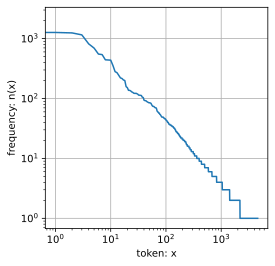

In [33]:
freqs = [freq for token, freq in vocab.token_freqs]

# plot token frequencies
d2l.plot(freqs,
         xlabel='token: x',
         ylabel='frequency: n(x)',
         xscale='log',
         yscale='log',
         figsize=(4, 4))

All the remaining words roughly follow a straight line on a log-log plot. This phenomenon is called *Zipf's law*, which states that the frequency $n_i$, of the $i$-th most frequent word is:
\begin{split}
n_i \propto \frac{1}{i^\alpha}
\end{split}
which is equivalent to
\begin{split}
\log n_i = -\alpha \log i + c
\end{split}
where $\alpha$ is the exponent that characterizes the distribution and $c$ is a constant.

If we want to model words by their frequencies, we will significantly overestimate the frequency of tail, also known as the infrequent words.

We can also consider the word combinations, such as two consecutive words (bigrams), three consecutive words (trigrams), and so on. The following code counts the frequencies of all the bigrams:

In [35]:
# words[:-1], words[1:] are the previous and next words
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)

# the ten most frequent bigrams
bigram_vocab.token_freqs[:20]

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73),
 ('i--saw', 68),
 ('i--could', 67),
 ('and--i', 62),
 ('in--a', 61),
 ('that--i', 61),
 ('time--traveller', 60),
 ('for--the', 51),
 ('to--me', 51),
 ('into--the', 49),
 ('at--the', 49)]

Nine out of ten most frequent word pairs are composed of both stop words and only one is relevant to the actual book -- "time time".

In [36]:
# trigram
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], # previous word
    words[1:-1], # current word
    words[2:], # next word
    )
]
trigram_vocab = Vocab(trigram_tokens)

# the ten most frequent trigrams
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

We can visualize the token frequency among three models: unigrams, bigrams, and trigrams:

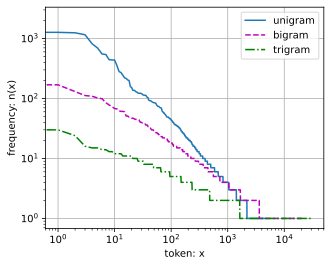

In [38]:
bigram_freq = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freq = [freq for token, freq in trigram_vocab.token_freqs]

# plot token frequencies
d2l.plot([freqs, bigram_freq, trigram_freq],
         xlabel='token: x',
         ylabel='frequency: n(x)',
         xscale='log',
         yscale='log',
         legend=['unigram', 'bigram', 'trigram'],
         figsize=(5,4))

1. Beyond unigram words, sequences of words also appear to be following Zipf's law, albeit with a smaller exponent $\alpha$, depending on the sequence length.
2. The number of distinct $n$-grams is not that large, which gives us hope that there is quite a lot of structure in language.
3. Many $n$-grams occur very rarely, which makes certain methods unsuitable for language modeling and motivates the use of deep learning models.

## 9.3. Language Models

Recall that we can map text sequences into tokens, where these tokens can be viewed as a sequence of discrete observations such as words or characters. Assume that the tokens in a text sequence of length $T$ are in turn $x_1, x_2, \ldots, x_T$. The goal of *language models* is to estimate the joint probability of the whole sequence:
\begin{split}
P(x_1, x_2, \ldots, x_T)
\end{split}

An ideal language model should generate natural text on its own, simply by drawing one token at a time $x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1)$.

In [1]:
import torch

from d2l import torch as d2l

### 9.3.1. Learning Language Models

Suppose that we tokenize text data at the word level. We start with applying the chain rule of probability:
\begin{split}
P(x_1, x_2, \ldots, x_T) = \prod_{t=1}^T P(x_t  \mid  x_1, \ldots, x_{t-1})
\end{split}

For example, the probability of a text sequence containing four words would be:
\begin{split}
\begin{aligned}
&P(\textrm{deep}, \textrm{learning}, \textrm{is}, \textrm{fun}) \\
=&P(\textrm{deep}) P(\textrm{learning}  \mid  \textrm{deep}) P(\textrm{is}  \mid  \textrm{deep}, \textrm{learning}) P(\textrm{fun}  \mid  \textrm{deep}, \textrm{learning}, \textrm{is})
\end{aligned}
\end{split}

#### 9.3.1.1. Markov Models and $n$-grams

A distribution over sequences satisfies the Markov property of first order if $P(x_{t+1} \mid x_t, \ldots, x_1) = P(x_{t+1} \mid x_t)$. Higher orders correspond to longer dependencies. This leads to a number of approximations that we could apply to model a sequence:
\begin{split}\begin{aligned}
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2) P(x_3) P(x_4),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_2) P(x_4  \mid  x_3),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_1, x_2) P(x_4  \mid  x_2, x_3).
\end{aligned}\end{split}
which are called *unigram*, *bigram*, and *trigram* models, respectively.

#### 9.3.1.2. Word Frequency

Assume that the training dataset is a large text corpus. The probability of words can be calculated from the relative word frequency of a given word in the training dataset. For example, the estimate $\hat{P}(\textrm{deep})$ can be calculated as the probability of any sentence starting with the word "deep". Or, a less accurate approach would be to count all occurrences of the word "deep" and divide it by the total number of words in the corpus. Then, we could attempt to estimate
\begin{split}
\hat{P}(\textrm{learning}  \mid  \textrm{deep}) = \frac{n(\textrm{deep learning})}{n(\textrm{deep})}
\end{split}
where $n(x)$ and $n(x, x')$ are the number of occurrences of singletons and consecutive word pairs, respectively.

Estimating the probability of a word pair is more difficult, not to mention for a longer sequence. Unless we provide some solution to assgin such word combinations a nonzero count, we will not be able to use them in a language model in a large dataset.

#### 9.3.1.3. Laplace Smoothing

*Laplace smoothing* is to add a small constant to all counts. Denote by $n$ the total number of words in the training set and $m$ the number of unique words. This solution helps with singletongs, e.g., via
\begin{split}\begin{aligned}
    \hat{P}(x) & = \frac{n(x) + \epsilon_1/m}{n + \epsilon_1}, \\
    \hat{P}(x' \mid x) & = \frac{n(x, x') + \epsilon_2 \hat{P}(x')}{n(x) + \epsilon_2}, \\
    \hat{P}(x'' \mid x,x') & = \frac{n(x, x',x'') + \epsilon_3 \hat{P}(x'')}{n(x, x') + \epsilon_3}.
\end{aligned}\end{split}
where $\epsilon_1, \epsilon_2$, and $\epsilon_3$ are hyperparameters. If $\epsilon_1 =0$, no smoothing is applied for singletons; if $\epsilon_1\leftarrow\infty$, $\hat{P}(x) = 1/m$ for all $x$ (uniform probability).

However, this solution gets unwieldy:
1. Many $n$-grams occur very rarely, making Laplace smoothing rather unsuitable for language modeling.
2. We need to store all counts.
3. This method entirely ignores the meaning of the words.
4. Long word sequences are almost certain to be novel, hence a model that simply counts the frequency of previously seen word sequences is bound to perform poorly there.

### 9.3.2. Perplexity

A good language model is able to predict, with high accuracy, the tokens that come next. Consider the following continuations of the phrase "It is raining", as proposed by different language models:
1. "It is raining outside"
2. "It is raining banana tree"
3. "It is raining piouw;kcj pwepoiut"

In terms of quality, Example 1 is clearly the best. The words are sensible and logically coherent.

A better language model should allow us to predict the next token more accurately. Thus, it should allow us to spend fewer bits in compressing the sequence. Therefore, we can measure it by the cross-entorpy loss averaged over all the $n$ tokens of a sequence:
\begin{split}
\frac{1}{n} \sum_{t=1}^n -\log P(x_t \mid x_{t-1}, \ldots, x_1),
\end{split}
where $P$ is given by a language model and $x_t$ is the actual token observed at time step $t$ from the sequence. This makes the performance on documents of different lengths comparable. The exponentiation of the cross-entropy loss is called *perplexity*:
\begin{split}
\textrm{perplexity} = \exp\left(-\frac{1}{n} \sum_{t=1}^n \log P(x_t \mid x_{t-1}, \ldots, x_1)\right)
\end{split}
Perplexity can be best understood as the reciprocal of the geometric mean of the number of real choices that we have when deciding which token to pick next.
* In the best case scenario, the model always perfectly estimates the probability of the target token as 1. In this case the perplexity of the model is 1.
* In the worst case scenario, the model always predicts the probability of the target token as 0. In this situation, the perplexity is positive infinity.
* At the baseline, the model predicts a uniform distribution over all the available tokens of the vocabulary. In this case, the perplexity equals the number of unique tokens of the vocabulary. In fact, if we were to store the sequence without any compression, this would be the best we could do for encoding it. Hence, this provides a nontrivial upper bound that any useful model must beat.

### 9.3.3. Partitioning Sequences

A language model needs to process a minibatch of sequences with predefined length at a time. To read minibatches of input sequences and target sequences at random, we need to partition sequences into smaller subsequences.

Suppose the dataset takes the form of a sequence of $T$ token indices in `corpus`. We will partition it into subsequences, where each subsequence has $n$ tokens (time steps). To iterate over (almost) all the tokens of the entire dataset for each epoch and obtain all possible length-$n$ subsequences, we can introduce randomness:
* At the beginning of each epoch, discard the first $d$ tokens, where $d\in[0, n)$ is uniformly sampled at random. The rest of the sequence is then partitioned into $m=\lfloor (T-d)/n \rfloor$ subsequences.
* Denote by $\mathbf x_t = [x_t, \ldots, x_{t+n-1}]$ the length-$n$ subsequence starting from token $x_t$ at time step $t$.
* The resulting $m$ partitioned subsequences are $\mathbf x_d, \mathbf x_{d+n}, \ldots, \mathbf x_{d+n(m-1)}$.
* Each subsequence will be used as an input sequence into the language model.

For language modeling, the goal is to *predict the next token based on the tokens we have seen so far*; hence the targets (labels) are the original sequence, shifted by one token. The target sequence for any input sequence $\mathbf x_t$ is $\mathbf x_{t+1}$ with length $n$.

![](../imgs/ch09/lang-model-data.svg)

The figure above shows an example of obtaining five pairs of input sequences and target sequences with $n=5$ and $d=2$.

In [3]:
@d2l.add_to_class(d2l.TimeMachine)
def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
    super(d2l.TimeMachine, self).__init__()
    self.save_hyperparameters()

    corpus, self.vocab = self.build(self._download())
    array = torch.tensor(
        [corpus[i : i+num_steps+1] for i in range(len(corpus)-num_steps)]
    )

    self.X, self.Y = array[:, :-1], array[:, 1:]

To train language models, we will randomly sample pairs of input sequences and target sequences in minibatches. 

We can implement a dataloader that randomly generates a minibatch from the dataset each time. The argument `batch_size` specifies the number of subsequence examples in each minibatch and `num_steps` is the subsequence length in tokens:

In [4]:
@d2l.add_to_class(d2l.TimeMachine)
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(self.num_train, self.num_train+self.num_val)
    return self.get_tensorloader([self.X, self.Y], train, idx)

A minibatch of target sequences can be obtained by shifting the input sequences by one token:

In [5]:
# create data
data = d2l.TimeMachine(batch_size=2, num_steps=10)

# check data
for X, Y in data.train_dataloader():
    print('X:', X, '\nY:', Y)
    break

X: tensor([[19,  6,  4, 16,  8, 15, 10, 27,  6,  5],
        [ 9,  6,  2, 19,  5,  0, 24,  9,  2, 21]]) 
Y: tensor([[ 6,  4, 16,  8, 15, 10, 27,  6,  5,  0],
        [ 6,  2, 19,  5,  0, 24,  9,  2, 21,  0]])


## 9.4. Recurrent Neural Networks

We have already described Markov models and $n$-grams for language modeling, where the conditional probability of token $x_t$ at time step $t$ only depends on the $n-1$ previous tokens. If we want to incorporate the possible effect of tokens earlier than time step $t-(n-1)$ on $x_t$, we need to increase $n$. However, as $n$ increases, the number of model parameters would also increase exponentially with it, as we need to store $O(|\mathcal{V}|^n)$ numbers for a vocabulary set $\mathcal{V}$.

Hence, rather than modeling $P(x_t \mid x_{t-1}, \ldots, x_{t-n+1})$, it is preferable to use a latent variable model,
\begin{split}
P(x_t \mid x_{t-1}, \ldots, x_1) \approx P(x_t \mid h_{t-1}),
\end{split}
where $h_{t-1}$ is a *hidden state* that stores the sequence information up to time step $t-1$. In general, the hidden state at any time step $t$ could be computed based on both the current input $x_t$ and the previous hidden state $h_{t-1}$:
\begin{split}
h_t = f(x_t, h_{t-1})
\end{split}

The hidden layers and hidden states refer to two very different concepts. Hidden layers are layers that are hidden from view on the path from input to output. *Hidden states*, by contrast, are *inputs* to whatever we do at a given step, and they can only be computed by looking at data at previous time steps.

*Recurrent neural networks* (RNNs) are neural networks with hidden states.

In [1]:
import torch

from d2l import torch as d2l

### 9.4.1. Neural Networks without Hidden States

Consider an MLP with a single hidden layer. Let the hidden layer's activation function be $\phi$. Given a minibatch of examples $\mathbf{X} \in \mathbb{R}^{n \times d}$ with batch size $n$ and $d$ inputs, the hidden layer output $\mathbf{H} \in \mathbb{R}^{n \times h}$ is calculated as
\begin{split}
\mathbf{H} = \phi(\mathbf{X} \mathbf{W}_{\textrm{xh}} + \mathbf{b}_\textrm{h})
\end{split}
where $\mathbf{W}_{\textrm{xh}} \in \mathbb{R}^{d \times h}$ is the weight parameter, $\mathbf{b}_\textrm{h} \in \mathbb{R}^{1 \times h}$ is the bias parameter, and $h$ is the number of hidden units.

The hidden layer output $\mathbf{H}$ is then used as the input for the output layer, which is given by
\begin{split}
\mathbf{O} = \mathbf{H} \mathbf{W}_{\textrm{hq}} + \mathbf{b}_\textrm{q}
\end{split}
where $\mathbf{O} \in \mathbb{R}^{n \times q}$ is the output variable, $\mathbf{W}_{\textrm{hq}} \in \mathbb{R}^{h \times q}$ is the weight parameter, and $\mathbf{b}_\textrm{q} \in \mathbb{R}^{1 \times q}$ is the bias parameter of the output layer.

### 9.4.2. Recurrent Neural Networks with Hidden States

Assume that we have a minibatch of inputs $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ at time step $t$. In other words, for a minibatch of $n$ sequence examples, each row of $\mathbf{X}_t$ corresponds to one example at time step $t$ from the sequence.

Next, denote by $\mathbf{H}_t \in \mathbb{R}^{n \times h}$ the hidden layer output of time step $t$. Unlike with MLP, here we save the hidden layer output $\mathbf{H}_{t-1}$ from the previous time step and introduce a new weight parameter $\mathbf{W}_{\textrm{hh}} \in \mathbb{R}^{h \times h}$ to describe how to use the hidden layer output of the previous time step in the current time step.

The calculation of the hidden layer output of the current time step is determined by the input of the current time step together with the hidden layer output of the previous time step:
\begin{split}
\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{\textrm{xh}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hh}}  + \mathbf{b}_\textrm{h})
\end{split}

Compared with MLPs, this adds one more term $\mathbf{H}_{t-1} \mathbf{W}_{\textrm{hh}}$. As a result, we know that $\mathbf{H}_t$  and $\mathbf{H}_{t-1}$ captured and retained the sequence's historical information up to their current time step, just like the state or memory of the neural network's current time step. Hence, such a hidden layer output is called a *hidden state*. Since the hidden state uses the same definition of the previous time step in the current time step, this computation is called *recurrent*. Therefore, neural networks with hidden states based on recurrent computation are named *recurrent neural networks*. Layers that perform the computation here in RNNs are called *recurrent layers*.

For time step $t$, the output of the output layer is similar to the computation in MLPs:
\begin{split}
\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{\textrm{hq}} + \mathbf{b}_\textrm{q}
\end{split}

Parameters of the RNNs include the weights $\mathbf{W}_{\textrm{xh}}\in \mathbb{R}^{d \times h}$, $\mathbf{W}_{\textrm{hh}}\in \mathbb{R}^{h \times h}$, and the bias $\mathbf{b}_\textrm{h} \in \mathbb{R}^{1 \times h}$ of the hidden layer, as well as the weights $\mathbf{W}_{\textrm{hq}} \in \mathbb{R}^{h \times q}$ and the bias $\mathbf{b}_\textrm{q} \in \mathbb{R}^{1 \times q}$ of the output layer. **Even at different time steps, RNNs always use these model parameters. The parameterization cost of an RNN does not grow as the number of time steps increases.**

![](../imgs/ch09/rnn.svg)

The figure above illustrates the computational logic of an RNN at three adjacent time steps. At any time step $t$, the computation of the hidden state can be treated as
1. concatenating the input $\mathbf{X}_t$ at the current time step $t$ and the hidden state $\mathbf{H}_{t-1}$ at the previous time step $t-1$;
2. feeding the concatenation result into a fully connected layer with the activation function $\phi$. The output of such a fully connected layer is the hidden state $\mathbf{H}_t$ at the current time step $t$. The model parameters are the concatenation of $\mathbf{W}_{\textrm{xh}}$ and $\mathbf{W}_{\textrm{hh}}$ and the bias $\mathbf{b}_\textrm{h}$.

The $\mathbf{H}_t$, hidden state of the current time step $t$, will participate in computing the hidden state $\mathbf{H}_{t+1}$ of the next time step $t+1$. $\mathbf{H}_t$ will also be fed into the fully connected output layer to compute the output $\mathbf{O}_t$ of the current time step $t$.

We can prove that the calculation of $\mathbf{X}_t \mathbf{W}_{\textrm{xh}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hh}}$ for the hidden state is equivalent to matrix multiplication of the concatenation of $\mathbf{X}_t$ and $\mathbf{H}_{t-1}$ and the concatenation of $\mathbf{W}_{\textrm{xh}}$ and $\mathbf{W}_{\textrm{hh}}$:

In [3]:
X, W_xh = torch.randn(3, 1), torch.randn(1, 4)
H, W_hh = torch.randn(3, 4), torch.randn(4, 4)

res1 = torch.matmul(X, W_xh) + torch.matmul(H, W_hh)
res1

tensor([[-1.1124, -0.6766, -3.3596, -0.1371],
        [-1.7861, -0.6887, -3.0263, -2.3288],
        [ 0.5526,  3.0804,  1.2878,  1.4689]])

In [4]:
res2 = torch.matmul(
    torch.cat((X, H), dim=1), # X is (3, 1), H is (3, 4)
    torch.cat((W_xh, W_hh), dim=0) # W_xh is (1, 4), W_hh is (4, 4)
)
res2

tensor([[-1.1124, -0.6766, -3.3596, -0.1371],
        [-1.7861, -0.6887, -3.0263, -2.3288],
        [ 0.5526,  3.0804,  1.2878,  1.4689]])

### 9.4.3. RNN-Based Character-Level Language Models

Let the minibatch size be one, and the sequence of the text be "machine". For simplicity, we tokenize text into characters and consider a *character-level language model*.

![](../imgs/ch09/rnn-train.svg)

The figure above shows how to predict the next characters. During the training process, we run a softmax operation on the output from the output layer for each time step, and then use the cross-entorpy loss to compute the error between the model output and the target.

Because of the recurrent computation of the hidden state in the hidden layer, the output, $\mathbf{O}_3$, of the time step 3 is determined by the text sequence "m", "a", and "c". Since the next character of the sequence in the training data is "h", the loss of time step 3 will depend on the probability distribution of the next character generated based on the feature sequence "m", "a", "c", and the target "h" of this time step.

In practice, each token is represented by a $d$-dimensional vector, and we use a batch size $n>1$. Therefore, the input $\mathbf{X}_t$ at time step $t$ will be an $n\times d$ matrix.

## 9.5. Recurrent Neural Network Implementation from Scratch

We will train a RNN to function as a character-level language model and train it on a corpus consisting of the entire text of H. G. Wells' *The Time Machine*.

In [17]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F

from d2l import torch as d2l

### 9.5.1. RNN Model

In [18]:
class RNNScratch(d2l.Module):
    '''The RNN model implemented from scratch'''
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        self.W_xh = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

In [19]:
# forward method
@d2l.add_to_class(RNNScratch)
def forward(self, inputs, state=None):
    '''Forward method
    
    Parameters
    ----------
    inputs : (num_steps, batch_size, num_inputs)
        Input data
    state : (batch_size, num_hiddens)
        Hidden state
    
    Returns
    -------
    outputs : (batch_size, num_steps, num_hiddens)
        Output data
    state : (batch_size, num_hiddens)
        Hidden state
    '''
    if state is None:
        # initial state with shape: (batch_size, num_hiddens)
        state = torch.zeros(
            (inputs.shape[1], self.num_hiddens), # (batch_size, num_hiddens)
            device=inputs.device # same device as inputs
        )
    else:
        state, = state # unpack tuple

    outputs = []
    for X in inputs: # shape of inputs: (num_steps, batch_size, num_inputs)
        state = torch.tanh(
            torch.matmul(X, self.W_xh) + torch.matmul(state, self.W_hh) + self.b_h
        )
        outputs.append(state)

    return outputs, state

In [3]:
@d2l.add_to_class(RNNScratch)  #@save
def forward(self, inputs, state=None):
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens)
        state = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
    else:
        state = state
    outputs = []
    for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
        state = torch.tanh(torch.matmul(X, self.W_xh) +
                         torch.matmul(state, self.W_hh) + self.b_h)
        outputs.append(state)
    return outputs, state

In [30]:
# the complete implementation of RNN
class RNNScratch(d2l.Module):
    '''The RNN model implemented from scratch'''
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        self.W_xh = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

    def forward(self, inputs, state=None):
        '''Forward method
        
        Parameters
        ----------
        inputs : (num_steps, batch_size, num_inputs)
            Input data
        state : (batch_size, num_hiddens)
            Hidden state
        
        Returns
        -------
        outputs : (batch_size, num_steps, num_hiddens)
            Output data
        state : (batch_size, num_hiddens)
            Hidden state
        '''
        if state is None:
            # initial state with shape: (batch_size, num_hiddens)
            state = torch.zeros(
                (inputs.shape[1], self.num_hiddens), # (batch_size, num_hiddens)
                device=inputs.device # same device as inputs
            )
        else:
            state, = state # unpack tuple

        outputs = []
        for X in inputs: # shape of inputs: (num_steps, batch_size, num_inputs)
            state = torch.tanh(
                torch.matmul(X, self.W_xh) + torch.matmul(state, self.W_hh) + self.b_h
            )
            outputs.append(state)

        return outputs, state

We can feed a minibatch of input sequences into an RNN model:

In [20]:
batch_size = 2
num_inputs = 16
num_hiddens = 32
num_steps = 100

X = torch.ones((num_steps, batch_size, num_inputs))
rnn = RNNScratch(num_inputs, num_hiddens)
outputs, state = rnn(X)
len(outputs), outputs[0].shape, state.shape

(100, torch.Size([2, 32]), torch.Size([2, 32]))

In [21]:
def check_len(a, n):
    '''Check the length of a list'''
    assert len(a) == n, f"list's length {len(a)} != expected length {n}"

def check_shape(a, shape):
    '''Check the shape of a tensor'''
    assert a.shape == shape, f"tensor's shape {a.shape} != expected shape {shape}"

In [22]:
check_len(outputs, num_steps)

In [23]:
check_shape(outputs[0], (batch_size, num_hiddens))

In [24]:
check_shape(state, (batch_size, num_hiddens))

### 9.5.2. RNN-Based Language Model

We will implement the `RNNLMScratch` class defining an RNN-based language model. We will use perplexity to evaluate the model, which ensures that sequences of different length are comparable.

In [25]:
class RNNLMScratch(d2l.Classifier):
    '''The RNN-based language model implemented from scratch'''
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()

        # initialize parameters
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens,
                self.vocab_size) * self.rnn.sigma
        )
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), # inputs
                      batch[-1], # targets
                      )
        self.plot('perplexity', torch.exp(l), train=True)
        return l
    
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), # inputs
                      batch[-1], # targets
                      )
        self.plot('perplexity', torch.exp(l), train=False)

#### 9.5.2.1. One-Hot Encoding

Recall that each token is represented by a numerical index indicating the position in the vocabulary of the corresponding word/character/word piece.

When dealing with such categorical data, the most common strategy is to represent each item by a *one-hot encoding*. A one-hot encoding is a vector whose length is given by the size of the vocabulary $N$, where all entries are set to 0, except for the entry corresponding to our token, which is set to 1.

In [26]:
# For example
F.one_hot(torch.tensor([0, 2]), # index
          num_classes=5, # vocab size
          )

tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])

The minibatches that we sample at each iteration will take the shape `(batch size, number of time steps)`. Once representing each input as a one-hot vector, each minibatch can be thought of as a *three-dimensional tensor*, where the length along the third axis is given by the vocabulary size (`len(vocab)`).

We usually transpose the input so that we will obtain an output of shape `(number of time steps, batch size, vocabulary size)`.

In [27]:
@d2l.add_to_class(RNNLMScratch)
def one_hot(self, X):
    # output shape: (num_steps, batch_size, vocab_size)
    res = F.one_hot(X.T, self.vocab_size) # one-hot encoding
    res = res.type(torch.float32) # convert to float32
    return res

#### 9.5.2.2. Transforming RNN Outputs

The language model uses a fully connected output layer to transform RNN outputs into token predictions at each time step:

In [28]:
@d2l.add_to_class(RNNLMScratch)
def output_layer(self, rnn_outputs):
    outputs = [
        torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs
    ]
    return torch.stack(outputs, dim=1)

@d2l.add_to_class(RNNLMScratch)
def forward(self, X, state=None):
    embeddings = self.one_hot(X)
    runn_outputs, _ = self.rnn(embeddings, state)
    return self.output_layer(runn_outputs)

In [29]:
# check forward computation
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))

### 9.5.3. Gradient Clipping

In addition to the passing through the network in the input-to-output direction, inputs at the first time step must pass through a chain of $T$ layers along the time steps in order to influence the output of the model at the final time step. In each iteration of the backpropagation, we backpropagate gradients through time, resulting in a chain of matrix-products of length $\mathcal{O}(T)$, which can lead to numerical instability, causing either gradients to explode or vanish.

One method to address this issue is to *clip* the gradients forcing the resulting "clipped" gradients to take smaller values.

Assume that we have an objective function $f$ to optimize and we iteratively update its parameters $\mathbf{x}$ using the gradient descent by pushing it in the direction of the negative gradient $\mathbf{g}$. With learning rate $\eta>0$, each update takes the form $\mathbf{x} \leftarrow \mathbf{x} - \eta \mathbf{g}$. Let's further assume that the objective function $f$ is sufficiently smooth. In other formal words, the objective function is *Lipschitz continuous* with constant $L$, meaning that for any $\mathbf{x}$ and $\mathbf{y}$ we have
\begin{split}
|f(\mathbf{x}) - f(\mathbf{y})| \leq L \|\mathbf{x} - \mathbf{y}\|
\end{split}

When we update the parameter vector by subtracting $\eta \mathbf{g}$, the change in the value of the obejctive depends on the learning rate, the norm of the gradient and $L$ as follows:
\begin{split}
|f(\mathbf{x}) - f(\mathbf{x} - \eta\mathbf{g})| \leq L \eta\|\mathbf{g}\|
\end{split}

In other words, the objective cannot change by more than $L \eta \|\mathbf{g}\|$. Although we limit the speed at which we can reduce the value of the objective by having a small value for this upper bound, this limits by just how much we can go wrong in any one gradeint step.

The gradient explosion means that $\|\mathbf{g}\|$ becomes excessively large. In this case, neural network training often diverges, failing to reduce the value of the objective. At other times, training eventually converges but is unstable owing to massive spikes in the loss.

One way to limit the size of $L \eta \|\mathbf{g}\|$ is to shrink the learning rate $\eta$ to tiny values. One popular alternative to allow *rare* large gradient values is to adopt a *gradient clipping* heuristic projecting the gradient $\mathbf{g}$ onto a ball of some given radius $\theta$ as follows:
\begin{split}
\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}
\end{split}
This ensures that the gradient norm never exceeds $\theta$ and that the updated gradient is entirely aligned with the original direction of $\mathbf{g}$.

Gradient clipping means that we are not always following the true gradient and it is hard to reason analytically about the possible side effects. However, it is a very useful hack, and is widely adopted in RNN implementations in most deep learning frameworks.

Now we can implement a method to clip gradients, which is invoked by the `fit_epoch` method of the `d2l.Trainer` class:

In [30]:
@d2l.add_to_class(d2l.Trainer)
def clip_gradients(self, grad_clip_val, model):
    # concatenate all model parameters
    params = [p for p in model.parameters() if p.requires_grad]
    # compute the global norm of all parameters
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))

    if norm > grad_clip_val:
        # clip the gradients if the global norm is greater than the threshold
        for param in params:
            param.grad[:] *= grad_clip_val / norm

### 9.5.4. Training

In [31]:
# load the Time Machine dataset
data = d2l.TimeMachine(batch_size=1024, 
                       num_steps=32)
# create RNN model
rnn = RNNScratch(num_inputs=len(data.vocab),
                 num_hiddens=32)
# create RNN-based language model
model = RNNLMScratch(rnn, 
                     vocab_size=len(data.vocab),
                     lr=1)
# create trainer
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)

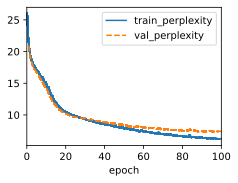

In [32]:
# train model
trainer.fit(model, data)

### 9.5.5. Decoding

Once a language model has been learned, we can use it not only to predict the next token but to continue predicting each subsequent one, treating the previously predicted token as though it were the next in the input.

We will implement a `predict` function to generate a continuation, one character at a time, after ingesting a user-provided `prefix`. When looping through the characters in `prefix`, we keep passing the hidden state to the next time step but do not generate any output. This is called the *warm-up* period. After ingesting the prefix, we are ready to begin emitting the subsequent characters, each of which will be fed back into the model as the input at the next time step:

In [33]:
@d2l.add_to_class(RNNLMScratch)
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]

    for i in range(len(prefix) + num_preds - 1):
        X = torch.tensor([[outputs[-1]]], device=device)
        embeddings = self.one_hot(X)

        rnn_outputs, state = self.rnn(embeddings, state)
        # warm-up period
        if i < len(prefix) - 1:
            outputs.append(vocab[prefix[i+1]])
        else:
            # predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(dim=2).reshape(1)))

    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [ ]:
# the complete implementation of RNN Language Model
class RNNLMScratch(d2l.Classifier):
    '''The RNN-based language model implemented from scratch'''
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()

        # initialize parameters
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(self.rnn.num_hiddens,
                        self.vocab_size) * self.rnn.sigma
        )
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1], batch[-1]))
        self.plot('perplexity', torch.exp(l), train=True)
        return l
    
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1], batch[-1]))
        self.plot('perplexity', torch.exp(l), train=False)

    def one_hot(self, X):
        # output shape: (num_steps, batch_size, vocab_size)
        res = F.one_hot(X.T, self.vocab_size) # one-hot encoding
        res = res.type(torch.float32) # convert to float32
        return res
    
    def output_layer(self, rnn_outputs):
        outputs = [
            torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs
        ]
        return torch.stack(outputs, dim=1)
    
    def forward(self, X, state=None):
        embeddings = self.one_hot(X)
        runn_outputs, _ = self.rnn(embeddings, state)
        return self.output_layer(runn_outputs)

In [34]:
prefix = 'it has'
num_preds = 20 # number of characters to predict

model.predict(prefix,
              num_preds,
              data.vocab,
              d2l.try_gpu())

'it has the the the the the'

## 9.6. Concise Implementation of Recurrent Neural Networks

In [35]:
import torch
from torch import nn
from torch.nn import functional as F

from d2l import torch as d2l

### 9.6.1. Defining the Model

In [36]:
class RNN(d2l.Module):
    '''The RNN model implemented using PyTorch'''
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()

        # define rnn layer
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

We will define the `RNNLM` class by inherting from the `RNNLMScratch` class in the previous section to define a complete RNN-based lagnuage model. We also need to create a separate fully connected output layer:

In [37]:
class RNNLM(d2l.RNNLMScratch):
    '''Thee RNN-based language model implemented with PyTorch'''
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)

    def output_layer(self, hiddens):
        out = self.linear(hiddens) # (num_steps, batch_size, vocab_size)
        out = out.swapaxes(0, 1) # (batch_size, num_steps, vocab_size)
        return out

### 9.6.2. Training and Predicting

In [44]:
# load the Time Machine dataset
data = d2l.TimeMachine(batch_size=1024, 
                       num_steps=32)

# create RNN model
rnn = RNN(num_inputs=len(data.vocab),
          num_hiddens=32)
# create RNN-based language model
model = RNNLM(rnn, 
              vocab_size=len(data.vocab),
              lr=1)
# create trainer
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)

# prediction arguments
prefix = 'it has'
num_preds = 20 # number of characters to predict

In [45]:
# check untrained model prediction
model.predict(prefix, num_preds, data.vocab)

'it hasmmmmmmmmmmmmmmmmmmmm'

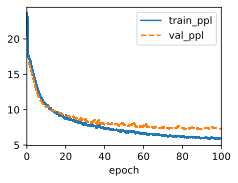

In [46]:
# train model
trainer.fit(model, data)

In [48]:
# check trained model prediction
model.predict(prefix, num_preds, data.vocab, d2l.try_gpu())

'it has of the praveller an'

## 9.7. Backpropagation Through Time

Similar to the forward and backward propagation through computational graphs for MLPs, the forward propagation in RNN is relatively straightforward. Applying backpropagation in RNNs is called *backpropagtion through time*, which expands (or unrolls) the computational graph of an RNN one time step at a time.

The unrolled RNN is essentially a feedforward neural network with shared parameters repeated throughout the unrolled network, appearing at each time step.

Complications arise because sequences can be rather long. It is not unusual to work with text sequences consisting of over a thousand tokens. Note that this poses problems both from a computational (too much memory) and optimization (numerical instability) standpoint. Input from the first step passes through over 1000 matrix products before arriving at the output, and another 1000 matrix products are required to compute the gradient.

### 9.7.1. Analysis of Gradients in RNNs

In a simplified RNN model, we denote $h_t$ as the hidden state, $x_t$ as input, and $o_t$ as output at time step $t$. The input and the hidden state can be concatenated before being multiplied by one weight variable in the hidden layer. Thus, we use $w_\textrm{h}$ and $w_\textrm{o}$ to indicate the weights of the hidden layer and the output layer, respectively. The hidden states and outputs at each time step are
\begin{split}
\begin{aligned}
h_t &= f(x_t, h_{t-1}, w_\textrm{h}),\\
o_t &= g(h_t, w_\textrm{o}),
\end{aligned}
\end{split}
where $f$ and $g$ are the activation functions of the hidden layer and the output layer, respectively. Hence, we have a chain of values $\{\ldots, (x_{t-1}, h_{t-1}, o_{t-1}), (x_{t}, h_{t}, o_t), \ldots\}$ that depend on each other via recurrent computation.

The forward propagation is to loop through the $(x_t, h_t, o_t)$ triples one time step at a time. The discrepancy between output $o_t$ and the desired target $y_t$ is then evaluated by an objective function across all the $T$ time steps as:
\begin{split}
L(x_1, \ldots, x_T, y_1, \ldots, y_T, w_\textrm{h}, w_\textrm{o}) = \frac{1}{T}\sum_{t=1}^T l(y_t, o_t)
\end{split}

When we compute the gradients with regard to the parameters $w_\textrm{h}$ of the objective function $L$ for backpropagation,
\begin{split}
\begin{aligned}
\frac{\partial L}{\partial w_\textrm{h}}  & = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial w_\textrm{h}}  \\
& = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial o_t} \frac{\partial o_t}{\partial h_t}  \frac{\partial h_t}{\partial w_\textrm{h}}\\
& = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial o_t} \frac{\partial g(h_t, w_\textrm{o})}{\partial h_t}  \frac{\partial h_t}{\partial w_\textrm{h}}
\end{aligned}
\end{split}

In the third factor $\frac{\partial h_t}{\partial w_\textrm{h}}$, since $h_t = f(x_t, h_{t-1}, w_\textrm{h})$, $h_t$ depends on both $h_{t-1}$ and $w_\textrm{h}$, where computation of $h_{t-1}$ also depends on $w_\textrm{h}$. Therefore, evaluating the total derivative of $h_t$ with regard to $w_\textrm{h}$ using the chain rule yields
\begin{split}
\frac{\partial h_t}{\partial w_\textrm{h}}= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}} +\frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_\textrm{h}}
\end{split}

To derive the above gradient, assume that we have three sequences $\{a_t\}, \{b_t\}, \{c_t\}$ satisfying $a_0=0$ and $a_t = b_t+c_t a_{t-1}$ for $t=1,2,\ldots$. Then, for $t\geq 1$,
\begin{split}
a_{t}=b_{t}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t}c_{j}\right)b_{i}
\end{split}

By substituting $a_t$, $b_t$, and $c_t$ according to
\begin{split}
\begin{aligned}
a_t &= \frac{\partial h_t}{\partial w_\textrm{h}},\\
b_t &= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}}, \\
c_t &= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}},
\end{aligned}
\end{split}

We can remove the recurrent computation with
\begin{split}
\frac{\partial h_t}{\partial w_\textrm{h}}=\frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t} \frac{\partial f(x_{j},h_{j-1},w_\textrm{h})}{\partial h_{j-1}} \right) \frac{\partial f(x_{i},h_{i-1},w_\textrm{h})}{\partial w_\textrm{h}}
\end{split}

The above equation is the backpropagation through time for RNNs. This chain can get very long whenever $t$ is large.

#### 9.7.1.1. Full Computation

If we want to compute the full sum of the gradients, this is very slow and gradients can blow up. This is similar to the butrterfly effect, where minimal changes in the initial conditions lead to disproportionate changes in the outcome.

#### 9.7.1.2. Truncating Time Steps

We can alternatively truncate the sum after $\tau$ steps, which leads to an *approximation* of the true gradient, simply by terminating the sum at $\partial h_{t-\tau}/\partial w_\textrm{h}$. This is called *truncated backpropagation through time* (TBPTT).

This may ask the model focus primarily on short-term influence rather than long-term consequences.

#### 9.7.1.3. Randomized Truncation

We can also replace $\partial h_t/\partial w_\textrm{h}$ by a random variable which is correct in expectation but truncates the sequence. We use a sequence of $\xi_t$ with predefined $0\leq \pi_t\leq 1$ where $P(\xi_t=0)=1 - \pi_t$ and $P(\xi_t=\pi_t^{-1})=\pi_t$, thus $\mathbb{E}[\xi_t]=1$. Then, we use this to replace the gradient $\partial h_t/\partial w_\textrm{h}$:
\begin{split}
z_t= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}} +\xi_t \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_\textrm{h}}
\end{split}
where the definition of $\xi_t$ is E[z_t] = \partial h_t/\partial w_\textrm{h}. Whenever $\xi_t=0$, the recurrent computation terminates at that time step $t$. This leads to a weighted sum of sequences of varying lengths, where long sequences are rare but appropriately overweighted.

#### 9.7.1.4. Comparing Strategies

![](../imgs/ch09/truncated-bptt.svg)

The figure above illustrates the three strategies for backpropagation through time for RNN:
1. The first row is the randomized truncation that partitions the text into segments of varying lengths.
2. The second row is the regular truncation that breaks the text into subsequences of the same length.
3. The third row is the full backpropagation through time that leads to a computational infeasible expression.

The  effect of an observation after a number of backpropagation steps into the past is quite sufficient to capture dependencies in practice. The increased variance counteracts the fact that the gradient is more accurate with more steps. We also want models that have only a short range of interactions.

### 9.7.2. Backpropagation Through Time in Detail

Consider an RNN without bias parameters, whose activation function in the hidden layer uses the identity mapping ($\phi(x)=x$) for simplicity. For time step $t$, let the single example input and the target be $\mathbf{x}_t \in \mathbb{R}^{d}$ and $y_t$, respectively. The hidden state $\mathbf{h}_t \in \mathbb{R}^{h}$ and the output $\mathbf{o}_t \in \mathbb{R}^{q}$ are computed as:
\begin{split}
\begin{aligned}
\mathbf{h}_t &= \mathbf{W}_\textrm{hx} \mathbf{x}_t + \mathbf{W}_\textrm{hh} \mathbf{h}_{t-1},\\
\mathbf{o}_t &= \mathbf{W}_\textrm{qh} \mathbf{h}_{t},
\end{aligned}
\end{split}
where $\mathbf{W}_\textrm{hx} \in \mathbb{R}^{h \times d}$, $\mathbf{W}_\textrm{hh} \in \mathbb{R}^{h \times h}$, and $\mathbf{W}_\textrm{qh} \in \mathbb{R}^{q \times h}$ are the weight parameters.

Denote by $l(\mathbf{o}_t, y_t)$ the loss at time step $t$. The objective function, the loss over $T$ time steps from the beginning of the sequence is
\begin{split}
L = \frac{1}{T} \sum_{t=1}^T l(\mathbf{o}_t, y_t)
\end{split}

![](../imgs/ch09/rnn-bptt.svg)

The figure above shows a computational graph of this RNN. The computation of the hidden states of time step 3, $\mathbf{h}_3$, depends on the model parameters $\mathbf{W}_\textrm{hx}$ and $\mathbf{W}_\textrm{hh}$, the hidden state of the previous time step $\mathbf{h}_2$, and the input of the current time step $\mathbf{x}_3$. 

Training this model requires gradient computation with respect to these parameters $\partial L/\partial \mathbf{W}_\textrm{hx}$, $\partial L/\partial \mathbf{W}_\textrm{hh}$, and $\partial L/\partial \mathbf{W}_\textrm{qh}$. According to the dependencies in the figure above, we can traverse in the opposite direcion of the arrows to calculate and store the gradients in turn.

First of all, differentiating the objective function with respect to the model output at any time step $t$:
\begin{split}
\frac{\partial L}{\partial \mathbf{o}_t} =  \frac{\partial l (\mathbf{o}_t, y_t)}{T \cdot \partial \mathbf{o}_t} \in \mathbb{R}^q
\end{split}

Then, we can calculate the gradient of the objective function with respect to the model parameters $\mathbf{W}_\textrm{qh}$ in the output layer: $\partial L/\partial \mathbf{W}_\textrm{qh} \in \mathbb{R}^{q \times h}$. According to the computational graph above, the objective $L$ depends on $\mathbf{W}_\textrm{qh}$ only via $\mathbf{o}_1, \ldots, \mathbf{o}_T$:
\begin{split}
\frac{\partial L}{\partial \mathbf{W}_\textrm{qh}}
= \sum_{t=1}^T \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{o}_t}, \frac{\partial \mathbf{o}_t}{\partial \mathbf{W}_\textrm{qh}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{o}_t} \mathbf{h}_t^\top
\end{split}
where $\partial L/\partial \mathbf{o}_t$ is what we have calculated above.

Next, at the final time step $T$, the objective function $L$ depends on the hidden state $\mathbf{h}_T$% only via $\mathbf{o}_T$. Therefore, the gradient $\partial L/\partial \mathbf{h}_T \in \mathbb{R}^h$ can be calculated using the chain rule:
\begin{split}
\frac{\partial L}{\partial \mathbf{h}_T} = \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{o}_T}, \frac{\partial \mathbf{o}_T}{\partial \mathbf{h}_T} \right) = \mathbf{W}_\textrm{qh}^\top \frac{\partial L}{\partial \mathbf{o}_T}
\end{split}

For any time step $t<T$, where the objective function $L$ depends on the hidden state $\mathbf{h}_t$ via $\mathbf{h}_{t+1}$ and $\mathbf{o}_t$, it will be more complicated and trickier. We can calculate the gradient $\partial L/\partial \mathbf{h}_t \in \mathbb{R}^h$ at any time step $t<T$ using the chain rule:
\begin{split}
\frac{\partial L}{\partial \mathbf{h}_t} = \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{h}_{t+1}}, \frac{\partial \mathbf{h}_{t+1}}{\partial \mathbf{h}_t} \right) + \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{o}_t}, \frac{\partial \mathbf{o}_t}{\partial \mathbf{h}_t} \right) = \mathbf{W}_\textrm{hh}^\top \frac{\partial L}{\partial \mathbf{h}_{t+1}} + \mathbf{W}_\textrm{qh}^\top \frac{\partial L}{\partial \mathbf{o}_t}
\end{split}

For analysis, expanding the recurrent computation for any time step $1\leq t \leq T$ gives
\begin{split}
\frac{\partial L}{\partial \mathbf{h}_t}= \sum_{i=t}^T {\left(\mathbf{W}_\textrm{hh}^\top\right)}^{T-i} \mathbf{W}_\textrm{qh}^\top \frac{\partial L}{\partial \mathbf{o}_{T+t-i}}
\end{split}

which is a simple linear function and exhibits some key problems of long sequence models: it involves potentially very large powers of $\mathbf{W}_\textrm{hh}^\top$. In it, eigenvalues smaller than 1 vanish and eigenvalues larger than 1 diverge. This is numerically unstable, which manifests itself in the form of vanishing and exploding gradients.

Finally, the objective function $L$ depends on model parameters $\mathbf{W}_\textrm{hx}$ and $\mathbf{W}_\textrm{hh}$ in the hidden layer via hidden states $\mathbf{h}_1, \ldots, \mathbf{h}_T$. Therefore, we can calculate the gradient $\partial L/\partial \mathbf{W}_\textrm{hx} \in \mathbb{R}^{h \times d}$ and $\partial L/\partial \mathbf{W}_\textrm{hh} \in \mathbb{R}^{h \times h}$ using the chain rule:
\begin{split}\begin{aligned}
\frac{\partial L}{\partial \mathbf{W}_\textrm{hx}}
&= \sum_{t=1}^T \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{h}_t}, \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_\textrm{hx}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{h}_t} \mathbf{x}_t^\top,\\
\frac{\partial L}{\partial \mathbf{W}_\textrm{hh}}
&= \sum_{t=1}^T \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{h}_t}, \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_\textrm{hh}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{h}_t} \mathbf{h}_{t-1}^\top,
\end{aligned}\end{split}
where $\partial L/\partial \mathbf{h}_t$ is recurrently computed above, and the computations of $\partial L/\partial \mathbf{h}_t$ is the key quantity that affects the numerical stability.